In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

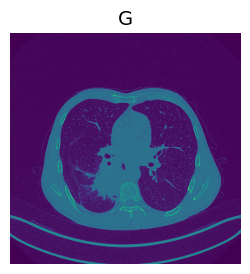

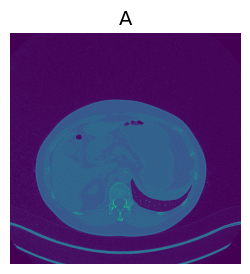

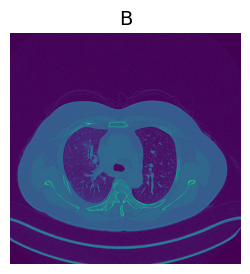

In [3]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

data_dir = "/Users/kesavreddy/Downloads/ModelTraining"
class_names = os.listdir(data_dir)

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    
    if os.path.isdir(class_path):
        image_files = [os.path.join(class_path, image_name) for image_name in os.listdir(class_path) if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        
        if not image_files:
            print(f"No image files found in {class_path}")
            continue
        
        selected_image = random.choice(image_files)
        
        img = Image.open(selected_image)
        plt.figure(figsize=(3, 3))
        plt.title(f"{class_name}", fontsize=14)
        plt.imshow(img)
        plt.axis('off')
        plt.show()


In [17]:
img_size = 224
batch_size = 32
num_classes = 3


In [18]:
import os
import pandas as pd

datadir = '/Users/kesavreddy/Downloads/ModelTraining'
category_dirs = [d for d in os.listdir(datadir) if os.path.isdir(os.path.join(datadir, d))]

category_counts = pd.DataFrame({'Category': category_dirs,'Count': [len(os.listdir(os.path.join(datadir, d))) for d in category_dirs]})

In [19]:
category_counts

,Category,Count
0,G,422
1,A,485
2,B,498


In [20]:
img_height = 224
img_width = 224

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="training",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  datadir,
  validation_split=0.2,
  subset="validation",
  label_mode = 'categorical',
  seed=123,
  image_size=(img_size, img_size),
  batch_size=32)

Found 1405 files belonging to 3 classes.
Using 1124 files for training.


Found 1405 files belonging to 3 classes.
Using 281 files for validation.


In [22]:
true_labels = []
for _, labels in train_ds:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))

# Calculate class weights based on class distribution
class_counts = np.bincount(true_labels)
total_samples = len(true_labels)
class_weights = total_samples / (len(class_counts) * class_counts)

class_weights_dict = dict(enumerate(class_weights))

In [23]:
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Use softmax for one-hot encoded labels
])

In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)       

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)



In [27]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights_dict  # Pass the computed class weights
)


Epoch 1/15


2023-11-15 11:05:29.779155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-15 11:05:29.815758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


36/36 [==============================] - 5s 60ms/step - loss: 1.6225 - accuracy: 0.3399 - val_loss: 1.0338 - val_accuracy: 0.5872 - lr: 0.0010
Epoch 2/15
36/36 [==============================] - 1s 39ms/step - loss: 0.9448 - accuracy: 0.5730 - val_loss: 0.8464 - val_accuracy: 0.5979 - lr: 0.0010
Epoch 3/15
36/36 [==============================] - 1s 38ms/step - loss: 0.6761 - accuracy: 0.7286 - val_loss: 0.7309 - val_accuracy: 0.7117 - lr: 0.0010
Epoch 4/15
36/36 [==============================] - 1s 39ms/step - loss: 0.4243 - accuracy: 0.8256 - val_loss: 0.4246 - val_accuracy: 0.8078 - lr: 0.0010
Epoch 5/15
36/36 [==============================] - 2s 41ms/step - loss: 0.2421 - accuracy: 0.9173 - val_loss: 0.2399 - val_accuracy: 0.9110 - lr: 0.0010
Epoch 6/15
36/36 [==============================] - 1s 38ms/step - loss: 0.1145 - accuracy: 0.9626 - val_loss: 0.3034 - val_accuracy: 0.9004 - lr: 0.0010
Epoch 7/15
36/36 [==============================] - 1s 38ms/step - loss: 0.1055 - accur

In [28]:
test_loss, test_acc = model.evaluate(val_ds)
print("Test accuracy:", test_acc)

9/9 [==============================] - 0s 13ms/step - loss: 0.1609 - accuracy: 0.9359
Test accuracy: 0.935943067073822


In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

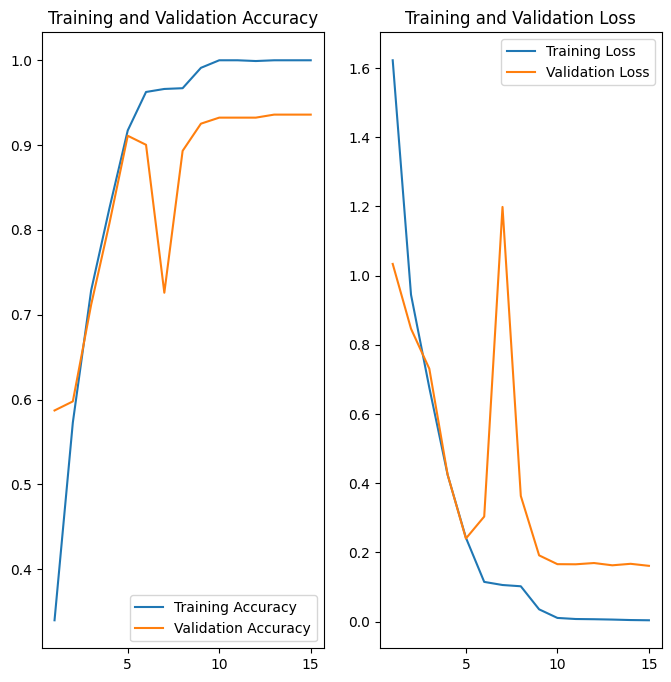

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
val_pred = model.predict(val_ds)
val_true_labels = np.concatenate([y for x, y in val_ds], axis=0)

val_pred_labels = np.argmax(val_pred, axis=1)
val_true_labels = np.argmax(val_true_labels, axis=1)

9/9 [==============================] - 0s 12ms/step


In [32]:
print("F1 score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))
print("Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(val_true_labels, val_pred_labels))


F1 score: 0.3808268454559716
Recall: 0.3807829181494662
Confusion Matrix:
 [[39 32 26]
 [35 35 30]
 [20 31 33]]


In [33]:
def get_class_names_from_one_hot(encoded_labels, class_names):
    return [class_names[label] for label in np.argmax(encoded_labels, axis=1)]


In [34]:
train_y_true = []
train_y_pred = []

for x, y in train_ds:
    train_y_true.extend(np.argmax(y.numpy(), axis=1))
    train_y_pred.extend(np.argmax(model.predict(x), axis=1))

# Map class indices to class names
train_y_true_class_names = get_class_names_from_one_hot(tf.keras.utils.to_categorical(train_y_true, num_classes), category_dirs)
train_y_pred_class_names = get_class_names_from_one_hot(tf.keras.utils.to_categorical(train_y_pred, num_classes), category_dirs)


class_names = {'A': 'Adinocarcinoma', 'B': 'Small Cell carcinoma', 'E': 'Large Cell Carcinoma', 'G': 'Squamous Cell Carcinoma'}

# Print the predicted and true class names for each example in the training set
for i in range(len(train_y_pred_class_names)):
    predicted_class_name = class_names[train_y_pred_class_names[i]]
    actual_class_name = class_names[train_y_true_class_names[i]]
    print(f"Predicted: {predicted_class_name}, Actual: {actual_class_name}")

# Calculate and print accuracy, recall, precision, and F1 score on the training set
train_accuracy = accuracy_score(train_y_true, train_y_pred)
train_recall = recall_score(train_y_true, train_y_pred, average='weighted')
train_precision = precision_score(train_y_true, train_y_pred, average='weighted', zero_division=0)
train_f1 = f1_score(train_y_true, train_y_pred, average='weighted')

print("Training Accuracy:", train_accuracy)
print("Training Recall:", train_recall)
print("Training Precision:", train_precision)
print("Training F1 Score:", train_f1)


1/1 [==============================] - 0s 45ms/step
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Small Cell carcinoma, Actual: Small Cell carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Squamous Cell Carcinoma, Actual: Squamous Cell Carcinoma
Predicted: Small Cell carcinoma, Actual: Small Cell carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Small Cell carcinoma, Actual: Small Cell carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Small Cell carcinoma, Actual: Small Cell carcinoma
Predicted: Adinocarcinoma, Actual: Adinocarcinoma
Predicted: Squamous Cell Car

In [35]:
model.save("CNNs.h5")
print("Model saved successfully.")

Model saved successfully.


/Users/kesavreddy/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
